In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import random

Get the Colorfullness, Brightness and Saturation of the thumbnails each

In [33]:
# -------------------------------
# Configuration
# -------------------------------
THUMBNAIL_FOLDER = 'Final_clustering/thumbnails-filtered'                   # Folder where thumbnails are stored
#change file names
CSV_FILE = 'Final_clustering/K=9/Cluster_Color_Profile_Final.csv'            # Input CSV with VideoID and color percentages
OUTPUT_CSV = 'Final_clustering/K=9/CBS_Count.csv'                           # Output CSV with metrics


# -------------------------------
# Helper Functions
# -------------------------------

def get_colorfulness(image):
    """Compute colorfulness metric of an image."""
    # Convert to float32 for precision
    B, G, R = cv2.split(image.astype("float"))
    
    # rg = R - G
    # yb = 0.5 * (R + G) - B
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)

    mean_rg = np.mean(rg)
    mean_yb = np.mean(yb)

    std_rg = np.std(rg)
    std_yb = np.std(yb)

    colorfulness = np.sqrt((std_rg ** 2) + (std_yb ** 2)) + \
                   0.3 * np.sqrt((mean_rg ** 2) + (mean_yb ** 2))
    return colorfulness


def get_brightness(image):
    """Compute brightness using HSP formula."""
    B, G, R = cv2.split(image.astype("float"))
    brightness = np.sqrt(0.241 * R**2 + 0.391 * G**2 + 0.068 * B**2)
    return np.mean(brightness)


def get_saturation(image):
    """Convert image to HSV and compute average saturation."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype("float32")
    S = hsv[:, :, 1]  # Saturation channel
    return np.mean(S) / 255.0  # Normalize to [0, 1]


# -------------------------------
# Main Processing
# -------------------------------

# Load the CSV data
df = pd.read_csv(CSV_FILE)

# Prepare new columns
df['colorfulness'] = np.nan
df['brightness'] = np.nan
df['saturation'] = np.nan

# Process each thumbnail
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Thumbnails"):
    vid_id = row['VideoID']
    img_path = os.path.join(THUMBNAIL_FOLDER, vid_id)

    if not os.path.exists(img_path):
        print(f"Image {img_path} not found.")
        continue

    try:
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
        
        df.at[idx, 'colorfulness'] = get_colorfulness(img)
        df.at[idx, 'brightness'] = get_brightness(img)
        df.at[idx, 'saturation'] = get_saturation(img)
    except Exception as e:
        print(f"Error processing {vid_id}: {e}")

# Save results
df.to_csv(OUTPUT_CSV, index=False)
print(f"\nMetrics saved to {OUTPUT_CSV}")

Processing Thumbnails: 100%|██████████| 2587/2587 [06:35<00:00,  6.53it/s]


Metrics saved to Final_clustering/K=9/CBS_Count.csv


Get the average of the CBS of each cluster

In [28]:
# Load your CSV file
df = pd.read_csv('Final_clustering/K=5/CBS_Count.csv')  #change file names

# Group by Cluster and compute average metrics
cluster_summary = df.groupby('Cluster')[['colorfulness', 'brightness', 'saturation']].mean()

# Normalize if needed (optional)
# Normalize to percentage scale based on max values across all clusters
cluster_summary['colorfulness (%)'] = (cluster_summary['colorfulness'] / df['colorfulness'].max()) * 100
cluster_summary['brightness (%)'] = (cluster_summary['brightness'] / df['brightness'].max()) * 100
cluster_summary['saturation (%)'] = cluster_summary['saturation'] * 100  # Already between 0–1

# Print formatted output
for cluster in sorted(cluster_summary.index):
    row = cluster_summary.loc[cluster]
    print(f"**Cluster {cluster}**")
    print(f"Colorfulness: {row['colorfulness (%)']:.2f}%")
    print(f"Brightness: {row['brightness (%)']:.2f}%")
    print(f"Saturation: {row['saturation (%)']:.2f}%")
    print()

**Cluster 0**
Colorfulness: 38.14%
Brightness: 65.45%
Saturation: 33.14%

**Cluster 1**
Colorfulness: 33.52%
Brightness: 37.35%
Saturation: 41.11%

**Cluster 2**
Colorfulness: 55.11%
Brightness: 60.23%
Saturation: 50.02%

**Cluster 3**
Colorfulness: 36.01%
Brightness: 52.11%
Saturation: 37.31%

**Cluster 4**
Colorfulness: 52.44%
Brightness: 56.02%
Saturation: 48.39%



Shows a random 5 pictures in each Cluster along with its CBS Percentage


Showing 5 random thumbnails from Cluster 0


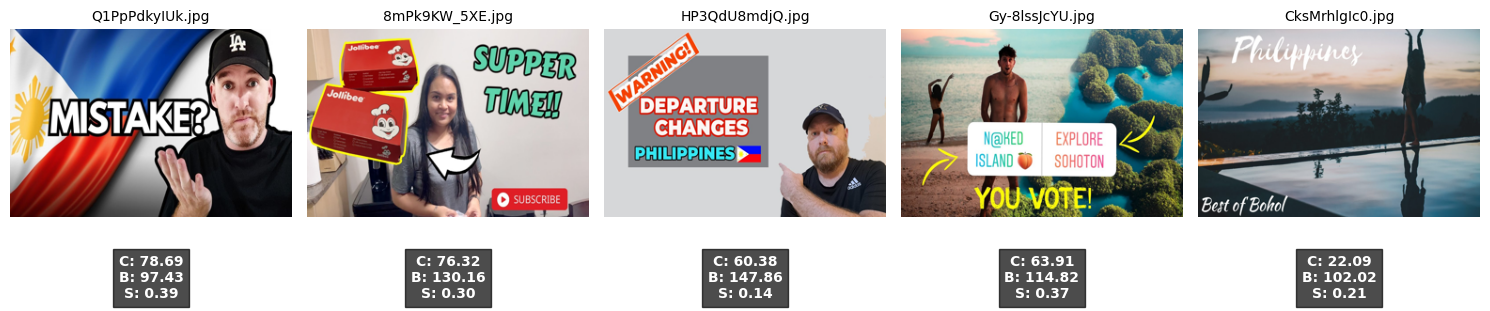


Showing 5 random thumbnails from Cluster 1


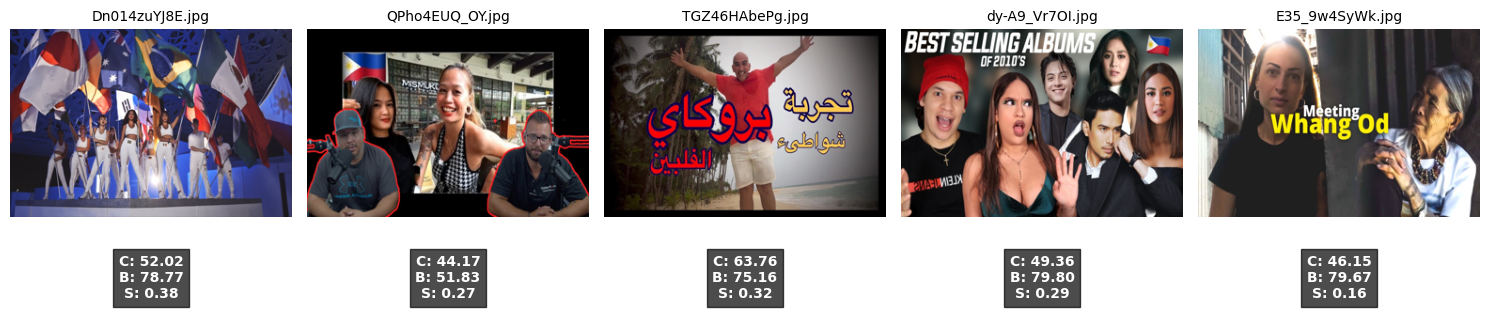


Showing 5 random thumbnails from Cluster 2


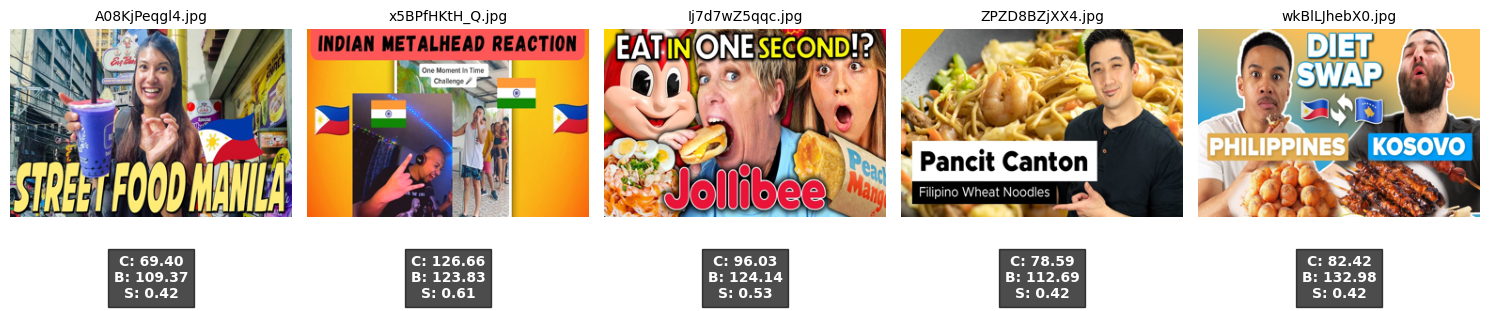


Showing 5 random thumbnails from Cluster 3


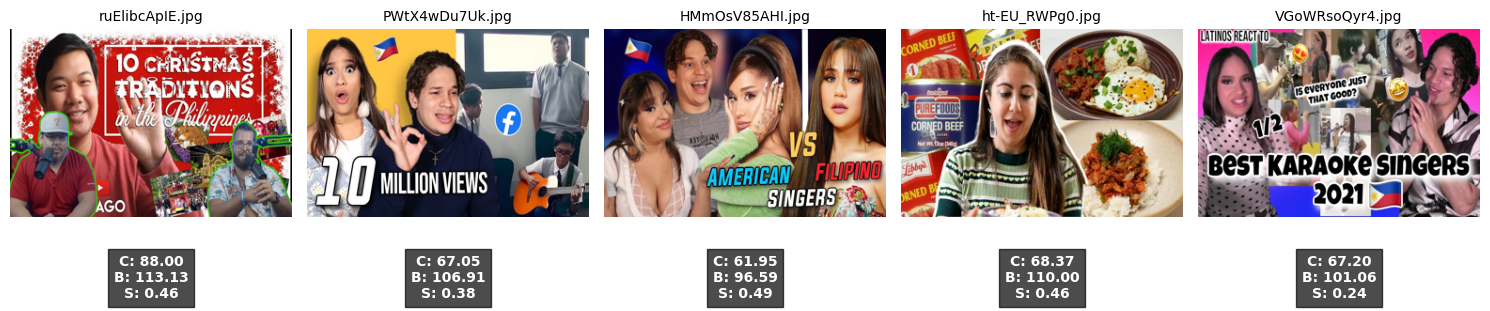


Showing 5 random thumbnails from Cluster 4


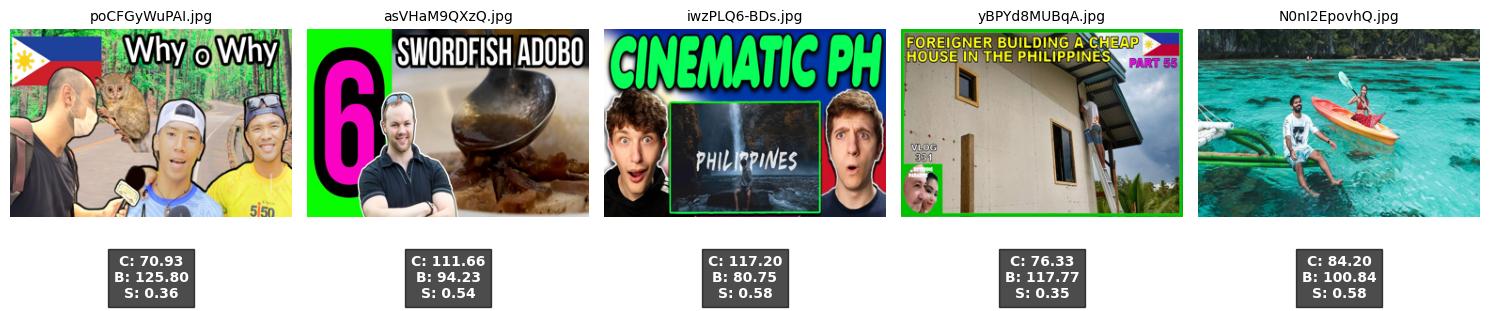

In [30]:
# -------------------------------
# Configuration
# -------------------------------
THUMBNAIL_FOLDER = 'Final_clustering/thumbnails-filtered'
#change file names
CSV_FILE = 'Final_clustering/K=5/CBS_Count.csv'
SAMPLES_PER_CLUSTER = 5

# -------------------------------
# Load Data
# -------------------------------
df = pd.read_csv(CSV_FILE)

# -------------------------------
# Function to Display Thumbnails with CBS Metrics
# -------------------------------
def show_thumbnails_with_cbs(cluster_id, group):
    print(f"\nShowing {SAMPLES_PER_CLUSTER} random thumbnails from Cluster {cluster_id}")
    
    # Sample up to 5 thumbnails randomly
    sample_group = group.sample(n=min(SAMPLES_PER_CLUSTER, len(group)), random_state=np.random.randint(0, 1000))  # Use a random seed
    
    # Setup figure
    fig, axes = plt.subplots(1, SAMPLES_PER_CLUSTER, figsize=(15, 6))
    if SAMPLES_PER_CLUSTER == 1:
        axes = [axes]
        
    
    
    for ax, (idx, row) in zip(axes, sample_group.iterrows()):
        vid_id = row['VideoID']
        c = row['colorfulness']
        b = row['brightness']
        s = row['saturation']
        
        img_path = os.path.join(THUMBNAIL_FOLDER, vid_id)
        
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            ax.axis('off')
            continue
        
        try:
            img = Image.open(img_path)
            img = img.resize((300, 200))  # Resize for consistent display
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            ax.axis('off')
            continue
        
        # Display image
        ax.imshow(img)
        ax.axis('off')
        
        # Add CBS labels directly below the thumbnail
        ax.text(
            0.5, -0.2,
            f"C: {c:.2f}\nB: {b:.2f}\nS: {s:.2f}",
            fontsize=10,
            color='white',
            weight='bold',
            ha='center',
            va='top',
            bbox=dict(facecolor='black', alpha=0.7, edgecolor='black'),
            transform=ax.transAxes  # Ensure text stays within the subplot
        )
        
        ax.set_title(f"{vid_id}", fontsize=10)
    
    plt.tight_layout()
    plt.show()

# -------------------------------
# Process Each Cluster
# -------------------------------
clusters = df['Cluster'].unique()
clusters.sort()

for cluster in clusters:
    cluster_data = df[df['Cluster'] == cluster]
    show_thumbnails_with_cbs(cluster, cluster_data)

Extraction that results with (VideoID and CBS percentage only)

In [2]:
# -------------------------------
# Configuration
# -------------------------------
THUMBNAIL_FOLDER = 'Final_clustering/thumbnails-filtered'                   # Folder where thumbnails are stored
CSV_FILE = 'Final_clustering/K=9/Cluster_Color_Profile_Final.csv'            # Input CSV with VideoID and color percentages
CBS_ONLY_CSV = 'Final_clustering/K=3/CBS_Percentages.csv'                   # Output CSV with only CBS percentages

# -------------------------------
# Helper Functions
# -------------------------------

def get_colorfulness(image):
    """Compute colorfulness metric of an image."""
    # Convert to float32 for precision
    B, G, R = cv2.split(image.astype("float"))
    
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)

    mean_rg = np.mean(rg)
    mean_yb = np.mean(yb)

    std_rg = np.std(rg)
    std_yb = np.std(yb)

    colorfulness = np.sqrt((std_rg ** 2) + (std_yb ** 2)) + \
                   0.3 * np.sqrt((mean_rg ** 2) + (mean_yb ** 2))
    return colorfulness


def get_brightness(image):
    """Compute brightness using HSP formula."""
    B, G, R = cv2.split(image.astype("float"))
    brightness = np.sqrt(0.241 * R**2 + 0.391 * G**2 + 0.068 * B**2)
    return np.mean(brightness)


def get_saturation(image):
    """Convert image to HSV and compute average saturation."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype("float32")
    S = hsv[:, :, 1]  # Saturation channel
    return np.mean(S) / 255.0  # Normalize to [0, 1]


# -------------------------------
# Main Processing
# -------------------------------

# Load the CSV data
df = pd.read_csv(CSV_FILE)

# Create new dataframe with only VideoID
cbs_df = pd.DataFrame()
cbs_df['VideoID'] = df['VideoID']

# Add CBS columns
cbs_df['colorfulness'] = np.nan
cbs_df['brightness'] = np.nan
cbs_df['saturation'] = np.nan

# Process each thumbnail
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing Thumbnails"):
    vid_id = row['VideoID']
    img_path = os.path.join(THUMBNAIL_FOLDER, vid_id)

    if not os.path.exists(img_path):
        print(f"Image {img_path} not found.")
        continue

    try:
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
        
        cbs_df.at[idx, 'colorfulness'] = get_colorfulness(img)
        cbs_df.at[idx, 'brightness'] = get_brightness(img)
        cbs_df.at[idx, 'saturation'] = get_saturation(img)
    except Exception as e:
        print(f"Error processing {vid_id}: {e}")

# Save CBS-only results
cbs_df.to_csv(CBS_ONLY_CSV, index=False)
print(f"\nCBS percentages saved to {CBS_ONLY_CSV}")

Processing Thumbnails: 100%|██████████| 2587/2587 [08:54<00:00,  4.84it/s]


CBS percentages saved to Final_clustering/K=3/CBS_Percentages.csv
